tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


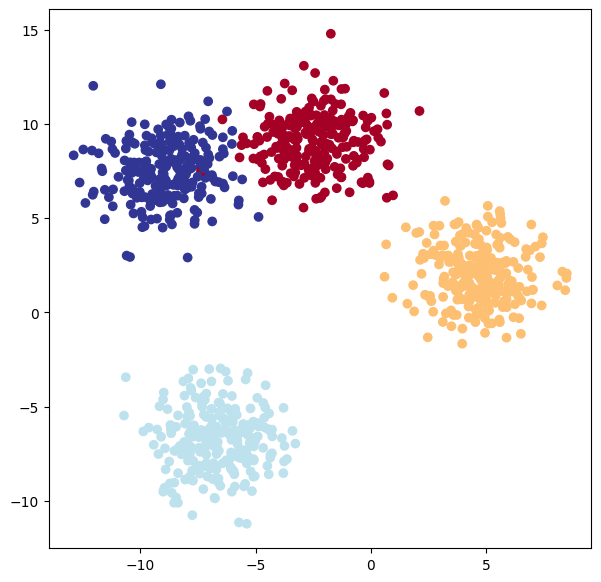

In [2]:
# import required Libraries

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, # x
                            centers=NUM_CLASSES,#y
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED
                            )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(X_blob[:5],y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED
                                                                        )
# 4. Plot
plt.figure(figsize=(7,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
# check the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
from torch import nn

# Model
class BlobModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units=8):
    """
    A model to be used on multi-class classification model
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_1 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [9]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)

In [11]:
model_1(X_blob_train.to(device))[:5]

tensor([[ 0.2950, -0.3468,  0.7520,  0.7834],
        [ 0.2302, -0.7012,  0.2246,  0.4314],
        [ 0.3764,  0.4582,  1.0023,  2.6086],
        [ 0.3412,  0.1474,  0.6491,  1.5568],
        [ 0.2635, -0.5458,  0.1456,  0.3645]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [12]:
model_1(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [13]:
# logits
y_logits = model_1(X_blob_test.to(device))

# Perform softmax
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.3025, -0.3803,  0.6000,  0.8761],
        [ 0.2516, -0.3946, -0.0390,  0.4317],
        [ 0.4050,  0.3140,  0.8216,  2.1113],
        [ 0.2924, -0.3254,  0.4733,  0.5242],
        [ 0.2692, -0.7818,  0.3378,  0.5422]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2162, 0.1092, 0.2910, 0.3836],
        [0.2883, 0.1510, 0.2156, 0.3451],
        [0.1119, 0.1021, 0.1697, 0.6163],
        [0.2501, 0.1348, 0.2997, 0.3153],
        [0.2678, 0.0936, 0.2868, 0.3518]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [14]:
# Sum the first sample output
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [15]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2162, 0.1092, 0.2910, 0.3836], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [16]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [18]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Training

  # 1. Forward pass
  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calc loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()

  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

  # Print out epoch stats
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.54542, Acc: 24.12% | Test Loss: 1.21536, Test Acc: 58.50%
Epoch: 10 | Loss: 0.49877, Acc: 98.00% | Test Loss: 0.42966, Test Acc: 99.50%
Epoch: 20 | Loss: 0.17364, Acc: 98.88% | Test Loss: 0.14811, Test Acc: 100.00%
Epoch: 30 | Loss: 0.09603, Acc: 99.12% | Test Loss: 0.08045, Test Acc: 99.50%
Epoch: 40 | Loss: 0.06808, Acc: 99.12% | Test Loss: 0.05541, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05455, Acc: 99.12% | Test Loss: 0.04307, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04675, Acc: 99.25% | Test Loss: 0.03591, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04174, Acc: 99.25% | Test Loss: 0.03124, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03830, Acc: 99.25% | Test Loss: 0.02800, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03580, Acc: 99.25% | Test Loss: 0.02561, Test Acc: 99.50%


In [19]:
# Predictions
model_1.eval()

with torch.inference_mode():
  y_logits = model_1(X_blob_test)

# View the first 10 preds
y_logits[:10]

tensor([[ 3.2228,  9.3712,  0.0548, -7.2723],
        [ 2.0098, -4.9329, -3.9744,  6.3697],
        [-1.8037,  2.1990,  8.7027, -2.6240],
        [ 1.5437,  5.6598, -0.1976, -3.6961],
        [ 7.9204,  3.0501, -5.4380, -4.0410],
        [ 2.2653, -5.7844, -4.7317,  7.5671],
        [-1.9753,  2.1547,  8.7157, -2.4270],
        [ 6.5425, -0.0317, -5.1412, -1.0710],
        [-1.8582,  2.3722,  9.3057, -2.9212],
        [ 7.1591,  0.8737, -5.3765, -2.1886]], device='cuda:0')

In [20]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

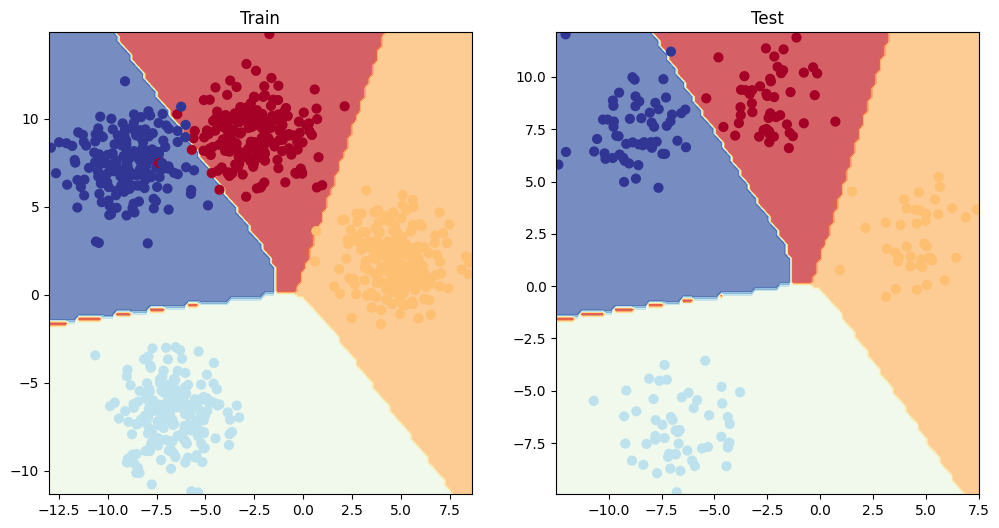

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)